# <center> Deep Q Learning </center>

In the previous notebook we looked at the basics of Q-learning employed in environments with discrete action and observation spaces. For real world problems this is not necessarily the case, thus simply constructing a Q-table and updating it with the Bellman Equation is not viable. In this notebook we are going to explore deep Q-learning in environments with continuous observation spaces (the action space is still discrete). 

## <center> OpenAI Gym's CartPole Environment </center>

<img src="openaigym.svg" width=200 />

We'll again be using environments from OpenAI Gym, but this time from the "classic control" set. In particular we will create a deep Q-learning agent to perform in the CartPole environment. This is a 2D environment in which a pole is balanced atop a movable cart, and the goal is to prevent the pole from falling over. There are two ways to fail: first if the pole leans over beyond an angle of 15 degrees (from the vertical) or the cart moves more than 2.4 "units" from the center of the environment. At each timestep, the agent must choose whether or move the cart either left or right or to do nothing; an action space of size 3. The maximum number of steps is fixed at 500, thus, a successful CartPole agent should be able to complete 500 steps without triggering one of these failure conditions. Lets have a first look at the environment:

[ 0.03067837  0.02647662 -0.0366504   0.00954282]


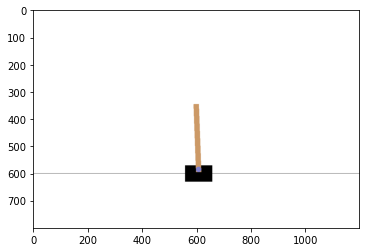

In [8]:
import gym
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
state = env.reset()
plt.imshow(env.render(mode='rgb_array'))
print(state)

Here the pole is the brown thing and the cart is the black thing which moves along the track represented by the grey line. We also see that the state of the environment is represented by four continuous values that represent the cart position, cart velocity, pole angle, and pole angular velocity. Our goal will be to create an agent that can take in these four values as an input and determine the optimal action to keep the pole upright. As with the FrozenLake, the environment outputs a reward for each action. For CartPole, a reward of one is given for any new state that is not a failed state and a reward of zero for failures.

For this task, we are going to employ an artificial neural network (NN) using the keras package. First let's try creating a super basic linear NN classifier with a single hidden layer of 8 neurons:

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# We'll create a Neural Network as a class that will be a part of our agent class later
class LinearClassifier():
    
    # The arguments required will be the learning rate, the number
    # of actions (3 possible for CartPole), and the dimensions of
    # the observation space (4 variables). We also include a save
    # directory and a name so we can save the final weights of our
    # model for verification at the end.
    def __init__(self,lrate,n_action,dimensions,save_dir='tmp/',name='CartBoi'):
        self.save_file = f'{save_dir}{name}.h5'
        
        # Here we are going to define our optimizer and our loss
        # functions. These determine exactly how the weights of
        # our model get updated at each learning step. We are going
        # to use the Adam optimizer and a mean squared error loss
        # function, which are fairly standard in this type of problem.
        # These will be called by our agent's "learn" function later.
        self.optimizer = keras.optimizers.Adam(learning_rate=lrate)
        self.loss = keras.losses.MeanSquaredError()
        
        # Now we define the layers of our neural network. 
        
        # In keras
        # we first need to define an input layer, which is given
        # a shape equivalent to the input dimensions. 
        Input = layers.Input(shape=dimensions)
    
        # Layer1 is the
        # hidden layer which contains 8 neurons, and uses an "relu"
        # activation function. Basically, each neuron will consist
        # of 4 values that are multiplied by the input values, summed,
        # then passed to the activation function to return a single number.
        # The activation function simply introduces non-linearity to the network.
        # Thus, we input 4 numbers, and Layer1 returns 8 numbers 
        # corresponding to each of the 64 neurons. Also, notice that
        # we specify that the Input layer is taken as the argument
        # of Layer1. As far as neural nets go, 8 is a fairly low number
        # of artifical neurons, but this is a fairly simple problems
        # so it seems to be suitable.
        Layer1 = layers.Dense(8, activation='relu')(Input)
        
        # Finally, we have the output layer, which will take the 64
        # values output by Layer1 and output a single value for each
        # of our 3 possible actions. Later, the agent will determine
        # the optimal action by passing the observations through this
        # neural network and choosing the action highest value in the
        # output layer. Note that our output layer does not employ
        # an activation function.
        Output = layers.Dense(n_action)(Layer1)
        
        # Now we put it all together
        self.model = keras.Model(inputs=Input,outputs=Output)
        
    # Finally we include functions for saving and loading the model weights
    def save_model(self):
        self.model.save(self.save_file)

Without the comments this is a pretty short piece of code. Essentially our network will take in the four values representing the dynamical state of the cart and pole system, pass this through it's 64 neurons, then perform a classification task on the resulting 64 values to determine what is the best action to take in the current state.

Now we just need to create our agent and make sure we give them this tiny, 64-neuron brain:

In [29]:
class CartBoi():
    
    # The required inputs are exactly the same as the 
    # neural network, but now we have a few extra kwargs
    # that you will recognize from the FrozenLake notebook.
    # First we have gamma, the "discount" factor that 
    # discounts future rewards when determining the Q-values
    # of a given action/state pair. Then we have epsilon, 
    # which determines the probability of taking a random
    # action. Finally we have the amount epsilon should be
    # decremented during each learning step and the minimum
    # value of epsilon.
    def __init__(self,lrate,n_actions,dimensions,
                 gamma=0.99,epsilon=1.0,e_dec=5e-5,
                 e_min=0.01,save_dir='tmp/',name='CartBoi'):
        # We start by assigning a bunch of attributes:
        self.gamma = gamma
        self.epsilon=epsilon
        self.emin = e_min
        self.de = e_dec
        self.action_space = [i for i in range(n_actions)]
        # This lets us keep track of how many learning steps we've taken
        self.steps = 0
        
        # Now we will give the agent it's brain by calling
        # the LinearClassifier we defined above
        self.brain = LinearClassifier(lrate,n_actions,dimensions,save_dir=save_dir,name=name)
        
    # Now we create a function for choosing a new action. 
    # This is essentially the same as for the FrozenLake agent
    # however, now when we don't take a random action we 
    # choose our optimal action based on the output of the
    # neural network. This function takes the 4 value state
    # vector from the CartPole environment as input
    def choose_action(self,state):
        # If a randomly chosen value between 0 and 1 is
        # less than the current epsilon, choose randomly.
        # e.g. epsilon = 0.5 means half random actions.
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.action_space)
        
        # If we aren't taking a random action, pass to
        # the brain! Keras/tensorflow works with tensors,
        # so we'll first have to convert to a tensor:
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor,0)
        
        # This line passes the input state through the
        # neural net and returns a vector with a single
        # value associated with each action
        actions = self.brain.model(state_tensor,training=False)
        
        # Finally, we return the action index with the
        # highest value as a numpy array
        return tf.argmax(actions[0]).numpy()
        
    # Here's the critical function, this is where our
    # agent learns. This is nearly identical to the
    # FrozenLakeAgent learn function, and again employs
    # the Bellman equation for updating the Q-values. 
    # The input here is the previous state/action pair 
    # and the resulting reward, done flag, and next_state
    # returned when taking the action in the CartPole
    # environment.
    def learn(self, state, action, reward, done, next_state):
        
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor,0)
        next_state_tensor = tf.convert_to_tensor(next_state)
        next_state_tensor = tf.expand_dims(next_state_tensor,0)
        
        # First we'll determine the value of being
        # in the new state, i.e. the maximum Q-value for
        # each action. This requires us to pass the next_state
        # through our neural network
        tmp = self.brain.model(next_state_tensor)
        V = tf.reduce_max(self.brain.model(next_state_tensor)[0])
        
        # Now we'll include a negative reward when we get
        # a done flag since we know this only happens for
        # a failure
        if done:
            reward = -50
        
        # Now we get the expectation value, which is the 
        # reward plus the value of the new state multiplied
        # by the discount factor
        Q_predicted = reward + self.gamma*V
        
        # Next is the training step, this looks a bit weird
        # but its how I implement it in tensorflow (there are
        # other ways...)
        with tf.GradientTape() as tape:
            # expectation from previous state:
            Q = self.brain.model(state_tensor)[0][action]
            Q_predicted = tf.expand_dims(Q_predicted,0)
            Q = tf.expand_dims(Q,0)
            tape.watch(Q)
            # compute the loss
            loss = self.brain.loss(Q_predicted,Q)
        gradient = tape.gradient(loss,self.brain.model.trainable_variables)
        self.brain.optimizer.apply_gradients(zip(gradient,self.brain.model.trainable_variables))
        
        # Finally, track the step number and update epsilon
        self.steps += 1
        if self.epsilon > self.emin: self.epsilon -= self.de    

OK now to create the main loop and train our CartPole agent:

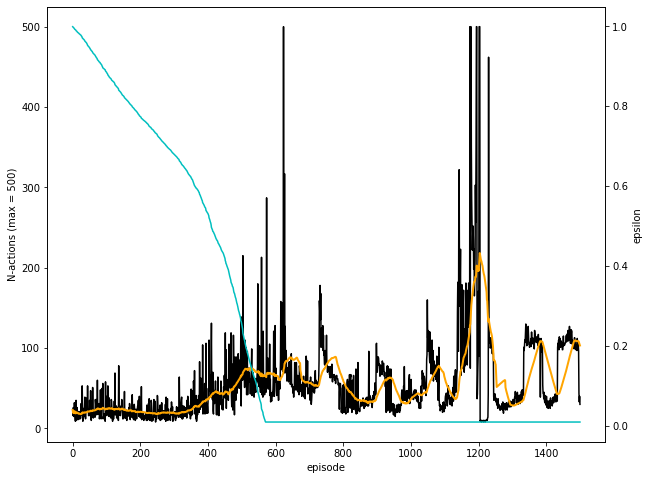

In [30]:
Cboi = CartBoi(
    0.001,
    env.action_space.n,
    env.observation_space.shape
)

# We'll keep track of how many steps the agent
# took during each episode (as well as the average
# of the past 50 episodes). Remember that the max
# is 500, so any score less than 500 means our
# agent failed at some point by either moving
# beyond the edge of the environment or by allowing
# the pole to fall over. We'll also keep track
# of the best effort and save the model weights
# each time we beat it. 
action_steps = []
epsilons = []
trailing_avg = []
episodes = []
best_steps = -100

# We'll run 1500 training episodes
n_episodes = 1500
for i in range(n_episodes):
    done = False
    state = env.reset()
    steps = 0
    while not done:
        action = Cboi.choose_action(state)
        new_state, reward, done, info = env.step(action)
        steps += reward
        
        # Once we manage to get to the maximum step number of 500
        # the environment will give a done flag of True in order to
        # terminate. In our agent we give a state with a True done flag a negative 
        # reward, however in the case of getting to 500 steps, we 
        # don't want a negative reward. To avoid this, if we reach
        # 500 steps we set the done flag to False before saving to
        # the memory cache.
        if steps == 500:
            done = False
        
        Cboi.learn(state,action,reward,done,new_state)
        state = new_state
        
        # If at 500 steps, we will set the done flag back to True after
        # saving to the memory cache in order to terminate the current
        # episode.
        if steps == 500:
            done = True
        
    action_steps.append(steps)
    episodes.append(i)
    epsilons.append(Cboi.epsilon)
    trailing_avg.append(np.mean(action_steps[-50:]))
    if steps > best_steps:
        best_steps = steps
        Cboi.brain.save_model()
        
F = plt.figure(figsize=(10,8))
ax = F.add_subplot(111)
ax.plot(episodes,action_steps,'k-')
ax.plot(episodes,trailing_avg,'-',lw=2,color='orange')
ax.set_xlabel('episode')
ax.set_ylabel('N-actions (max = 500)')
xa = ax.twinx()
xa.plot(episodes,epsilons,'c-')
xa.set_ylabel('epsilon')
plt.show()

OK, so it seems that our agent is learning something (with its puny, 8 neuron brain), and even managed to get to the maximum number of steps sometimes. Overall, the average of the past 50 episodes (orange line) sits at around 50-100 after our exploratory phase is over, so not super great really. There are definitely ways to stabilise learning, for example by employing a memory buffer where the agent actually stores it's memories and learns from a sample of memories each time (rather than only learning from the current state). For environments with larger, more complex observation spaces than Cart Pole, storing memories for future learning is actually a critical component.

In fact, such a memory buffer was one of the breakthroughs that allowed reinforcement learning to begin excelling at playing Atari (https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf). To improve our agent's learning, we'll employ a memory for our agent as a separate class that will be inherited.

## Giving Our Agent a Memory

The "ExperienceCache" class will basically be a set of numpy arrays where we can store the current state, the current reward, the action taken, the resulting next state, and wether or not we are at a terminal state (i.e. done = True). We will give it two functions, one will store the current memory and the other will allow our agent to access N previous memories where N is our "batch size". 

In [35]:
class ExperienceCache():
    def __init__(self,maxsize,inputshape):
        self.memsize = maxsize
        self.memcount = 0
        self.state_memory = np.zeros((maxsize,*inputshape),dtype=np.float32)
        self.next_state_memory = np.zeros((maxsize,*inputshape),dtype=np.float32)
        self.reward_memory = np.zeros(maxsize,dtype=np.float32)
        self.action_memory = np.zeros(maxsize,dtype=np.int64)
        self.done_memory = np.zeros(maxsize,dtype=np.float32)

    def store_memory(self,state, action, reward, done, next_state):
        index = self.memcount%self.memsize
        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.done_memory[index] = done
        self.memcount+=1

    def get_batch(self,batch_size):
        mxind = min(self.memcount,self.memsize)
        batch = np.random.choice(mxind,batch_size,replace=False)

        states = np.array(self.state_memory[batch])
        next_states = np.array(self.next_state_memory[batch])
        rewards = np.array(self.reward_memory[batch])
        actions = np.array(self.action_memory[batch])
        dones = np.array(self.done_memory[batch]).astype(int)

        return states, actions, rewards, dones, next_states

Now we'll recreate our CartBoi agent, but this time we'll give it a memory! I'll remove all of the previous comments and only highlight the changes in this version

In [36]:
class CartBoi():
    
    # Here we've added two kwargs, first the batch size, which is the
    # number of memories that will be sampled each step for learning, and
    # second is "explore_steps", which is how many steps we take at the
    # starting epsilon value before starting to learn. This ensures that 
    # once we start learning we have a large store of semi-random actions
    # to learn from.
    def __init__(self,lrate,n_actions,dimensions,
                 gamma=0.99,epsilon=.5,e_dec=1.e-5,
                 e_min=0.1,save_dir='tmp/',name='CartBoi',
                 batch_size=64, explore_steps = 1000):
        
        self.gamma = gamma
        self.epsilon=epsilon
        self.emin = e_min
        self.de = e_dec
        self.batch = batch_size
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.steps = 0
        self.exp = explore_steps
        
        self.brain = LinearClassifier(lrate,n_actions,dimensions,save_dir=save_dir,name=name)
        # Here we're giving the agent a memory. We'll let it store a maximum of 500
        # previous experiences. You'll see in the ExperienceCache class that once the
        # memory is full, the agent begins overwriting previous memories starting with
        # the earliest one
        self.memory = ExperienceCache(500,dimensions)
        
    def choose_action(self,state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.action_space)
    
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor,0)
        
        actions = self.brain.model(state_tensor,training=False)
        
        return tf.argmax(actions[0]).numpy()
        
    def learn(self, state, action, reward, done, next_state):
        # First we check if we've reached the end of the exploration
        # phase. If not we skip learning and leave epsilon fixed
        if self.memory.memcount < self.exp:
            return
        
        # Here we sample states, actions, rewards, "dones", and next_states
        # from the agent's memory. We'll return arrays for each one with N
        # examples where N is the specified batch size. Also note that the
        # current state/action may or may not be included, its up to chance.
        # This is what is known as "off-policy" learning.
        state, action, reward, done, next_state = self.memory.get_batch(self.batch)
        
        # This is basically the same, though remember we're now dealing with
        # multiple examples rather than just one
        V = tf.reduce_max(self.brain.model(next_state,training=False),axis=1)
        
        # Now we'll include a negative reward when we get
        # a done flag since we know this only happens for
        # a failure. Here "done" is an array of 1s and 0s, 
        # so we're essentially using it as a mask. Note that
        # when we're at a terminal state, we set the expected future
        # reward to 0 (i.e. the value of V)
        V = V*(1-done)
        reward = reward - (50.*done)
        
        Q_predicted = reward + self.gamma*V
        
        with tf.GradientTape() as tape:
            # expectation from previous state:
            Q = self.brain.model(state)
            # Here we're getting the Q values for each action taken for those
            # memories sampled from our buffer.
            Q = tf.reduce_sum(tf.multiply(Q,tf.one_hot(action,self.n_actions)),axis=1)

            loss = self.brain.loss(Q_predicted,Q)
        gradient = tape.gradient(loss,self.brain.model.trainable_variables)
        self.brain.optimizer.apply_gradients(zip(gradient,self.brain.model.trainable_variables))
        
        self.steps += 1
        if self.epsilon > self.emin: self.epsilon -= self.de

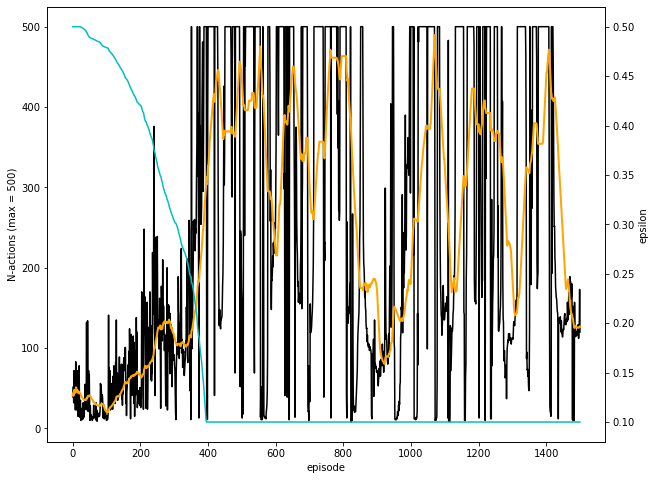

In [37]:
Cboi = CartBoi(
    0.001,
    env.action_space.n,
    env.observation_space.shape
)

# This will be nearly the same as last time, we just need
# to remember to store the memories in our memory buffer each time
action_steps = []
epsilons = []
trailing_avg = []
episodes = []
best_steps = -100

n_episodes = 1500
for i in range(n_episodes):
    done = False
    state = env.reset()
    steps = 0
    while not done:
        action = Cboi.choose_action(state)
        new_state, reward, done, info = env.step(action)
        steps += reward
        
        if steps == 500:
            done = False
        
        Cboi.learn(state,action,reward,done,new_state)
        # here's where we add the current states etc to the memory
        Cboi.memory.store_memory(state,action,reward,done,new_state)
        state = new_state
        
        if steps == 500:
            done = True
        
    action_steps.append(steps)
    episodes.append(i)
    epsilons.append(Cboi.epsilon)
    trailing_avg.append(np.mean(action_steps[-50:]))
    if steps > best_steps:
        best_steps = steps
        Cboi.brain.save_model()
        
F = plt.figure(figsize=(10,8))
ax = F.add_subplot(111)
ax.plot(episodes,action_steps,'k-')
ax.plot(episodes,trailing_avg,'-',lw=2,color='orange')
ax.set_xlabel('episode')
ax.set_ylabel('N-actions (max = 500)')
xa = ax.twinx()
xa.plot(episodes,epsilons,'c-')
xa.set_ylabel('epsilon')
plt.show()

OK! That's clearly much better than our memory-less agent, we've even managed to achieve some significant win streaks. Clearly there are still issues as we can see periods of perfect performace followed by abysmal failure. This is a known problem in deep Q-learning, sometimes referred to as "catastrophic forgetting". A quick Google search reveals that there are a different methods for addressing this issue (and I leave it up to the curious to attempt an implementation). Overcoming catastrophic forgetting in RL may be critical in cases where ongoing learning is important and where new and novel observations may be expected (i.e. something that hasn't been seen before). In the case of the CartPole, however, we're dealing with a static environment; once we've mastered it, there's no reason to continue learning! Let's try one more time, and this time we'll include a stopping criterion at which point we skip the learning step for the remainder of the run.

## CartPole Perfection:

We don't need to change anything with our agent, just update the training loop. This time we'll check when our agent has managed to reach 500 steps 5 times in a row, then suspend learning from that point onwards:

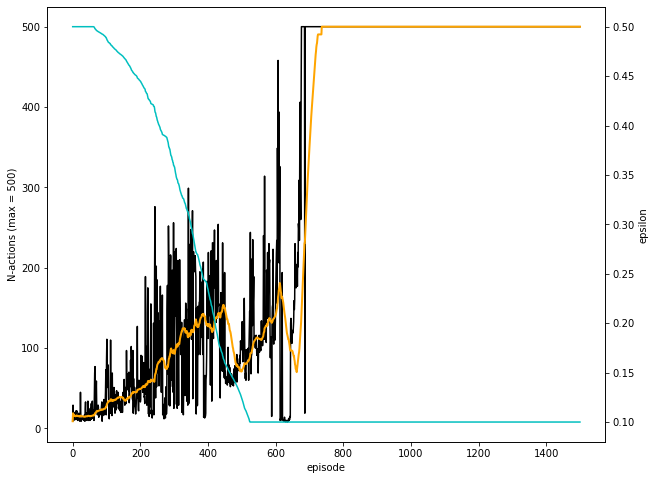

In [56]:
Cboi = CartBoi(
    0.001,
    env.action_space.n,
    env.observation_space.shape
)

# This will be nearly the same as last time, we just need
# to remember to store the memories in our memory buffer each time
action_steps = []
epsilons = []
trailing_avg = []
episodes = []
best_steps = -100

n_episodes = 1500
# Here's our "learn flag", once we reach our stopping criterion
# this will be switched to False
learn = True
for i in range(n_episodes):
    done = False
    state = env.reset()
    steps = 0
    while not done:
        action = Cboi.choose_action(state)
        new_state, reward, done, info = env.step(action)
        steps += reward
        
        if steps == 500:
            done = False
        
        # Only learn if learn is True
        if learn:
            Cboi.learn(state,action,reward,done,new_state)
            Cboi.memory.store_memory(state,action,reward,done,new_state)
        state = new_state
        
        if steps == 500:
            done = True
            
        # Check is stopping criterion is reached and, if so, change
        # learn to False. We won't put a break here, but instead we'll
        # let the rest of the episodes play out. This will confirm that
        # our agent has reached CartPole perfection! Again, we will 
        # disable learning once our agent wins 5 episodes in a row
        if np.mean(action_steps[-5:]) == 500:
            learn = False
        
    action_steps.append(steps)
    episodes.append(i)
    epsilons.append(Cboi.epsilon)
    trailing_avg.append(np.mean(action_steps[-50:]))
    if steps > best_steps:
        best_steps = steps
        Cboi.brain.save_model()
        
F = plt.figure(figsize=(10,8))
ax = F.add_subplot(111)
ax.plot(episodes,action_steps,'k-')
ax.plot(episodes,trailing_avg,'-',lw=2,color='orange')
ax.set_xlabel('episode')
ax.set_ylabel('N-actions (max = 500)')
xa = ax.twinx()
xa.plot(episodes,epsilons,'c-')
xa.set_ylabel('epsilon')
plt.show()

(disclaimer: this doesn't always work perfectly...)

and we've done it! Our agent can reach 500 steps every single time! Although these plots tell the story, but they're a bit abstract. Now that our agent can beat the CartPole, we might like to watch it in action. We can do this using a modified version of our training loop with the learning removed and using the .render() function of the CartPole environment. Below is how this would be accomplished from the terminal, however this doesn't work particularly well in a jupyter notebook.

In [66]:
"""
state = env.reset()
env.render()
done = False
while not done:
    action = Cboi.choose_action(state)
    new_state, reward, done, info = env.step(action)
    state = new_state
    env.render()
"""

'\nstate = env.reset()\nenv.render()\ndone = False\nwhile not done:\n    action = Cboi.choose_action(state)\n    new_state, reward, done, info = env.step(action)\n    state = new_state\n    env.render()\n'

For your viewing pleasure, however, here's one I've prepared earlier:

<img src="cpole_perfect.gif" width=500 />

You'll notice that the cart seems to drift towards the left rather than staying perfectly centred. Perhaps you could retrain the network and incentivise the agent to stay at the centre of the screen, either by increasing the reward when closer to the middle or reducing it when further from the centre. My goal was simply to reach the stopping criterion of 500 steps, so mission accomplished!

And that's it, deep Q-learning with the CartPole environment! The agent we've put together here is fairly generalizable to other "classic control" environments, and so far I've successfully adapted it to AcroBot and MountainCar. The key thing that needs to be adjusted in each case are the values of the rewards. Have a go and see if you can adapt this agent to those as well. It's possible that this agent could also be used for some of the other environment types as well, though in the case of the Atari environments, you will need to (at the very least) include a convolutional neural network (CNN) to interpret the visual input of the Atari screen (as described in the paper cited above).